# source code

In [456]:
from random import *
from itertools import *
import numpy as np
from franke import FrankeFunction
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
%matplotlib inline

np.random.seed(2019)

def create_data(points = 10000, noise = .01):
    
    x = np.random.random(size = points)
    y = np.random.random(size = points)
    z = FrankeFunction(x, y)
    
    if noise:
        z_noise = z + np.random.normal(0, noise, size = z.shape[0])
    
    return x, y, z, z_noise

class Regression_methods(object):
    def __init__(self, A, y, lamb = 0):
        try:
            A.shape       
        except AttributeError:
            A = np.array(A)
        try:
            y.shape
        except AttributeError:
            y = np.array(y)
        if A.shape[0] != y.shape[0]:
            msg = 'Matrix and Vector must have compatable dimensions for matrix math'
            raise Exception(msg)
        
        self._A = A
        self._y = y
        self._lamb = lamb
        self._hessian = A.T @ A
    
    @property
    def beta(self):
        try:
            return self._beta
        except:
            if (self._lamb == 0 or self._lamb == None):
                self._beta = np.linalg.pinv(self._hessian) @ self._A.T @ self._y
                #u,s,v = np.linalg.svd(self._A)
                #c = np.dot(u.T,self._y)
                #w = np.linalg.solve(np.diag(s),c)
                #self._beta = np.dot(v.T,w)
                return self._beta
            
            else:
                n = self._hessian.shape[0]
                self._beta = np.linalg.inv(self._hessian + self._lamb*np.eye(n)) @ self._A.T @ self._y
                return self._beta
    
    @property
    def y_tilde(self):
        try:
            return self._y_tilde
        except:
            self._y_tilde = self._A @ self.beta
            return self._y_tilde
    
    
    @property
    def sigma_y_sqr(self):
        n = self._y.size
        p = self._hessian.shape[0]
        self._sigma_y_sqr = 1/(n-p-1) * np.sum((self._y-self.y_tilde)**2)
        return self._sigma_y_sqr
    
    @property
    def beta_var(self):
        try:
            return self._beta_var
        except:
            self._beta_var = np.linalg.inv(self._hessian) * self.sigma_y_sqr
            return self._beta_var
    
    @property
    def hessian(self):
        return self._hessian
    
    def R2score(self): #FIX SHIT HERE!!!
        self.y_tilde
        return 1 - np.sum((self._y - self._y_tilde) ** 2) / np.sum((self._y - np.mean(self._y)) ** 2)

    def ms_error(self):
        self.y_tilde
        return np.sum((self._y-self._y_tilde)**2)/np.size(self._y_tilde)

    
def no_resample_analysis(regression_object, method = 'ols', lamb = 0):
    
    n = regression_object._y.shape[0]
    
    if (method == 'ols'):
        betavar = np.diag(regression_object.beta_var)
        sigma = regression_object.sigma_y_sqr
        mse = regression_object.ms_error()
        r2 = regression_object.R2score()
        
    if (method == 'ridge'):
        sigma = regression_object.sigma_y_sqr
        x = regression_object.hessian
        W = np.linalg.inv(x+lamb*np.eye(x.shape[0]))@x
        betavar = np.diag(sigma*W@np.linalg.inv(x)@W.T)
        mse = regression_object.ms_error()
        r2 = regression_object.R2score()
    
    print('NO RESAMPLE ANALYSIS')
    print('MSE: ', mse)
    print('R2 Score: ', r2)
    print('----Confidence Intervals for Selected Beta----')
    for i in range(len(betavar)):
        if i in np.arange(0,len(betavar)+1,2):
            print('\u03B2{:} = {:.3} +- {:.3}'.format(i, regression_object.beta[i], 1.645*np.sqrt(betavar[i]/n)))
    
    return betavar, sigma, mse, r2

def lasso_analysis(X, zdata, lamb):
    reg = Lasso(alpha = lamb, fit_intercept=False)
    reg.fit(X,zdata)
    beta = reg.coef_
    zpred = X @ beta
    
    err = ms_error(zdata, zpred)
    r2 = R2score(zdata, zpred)
    
    return err, r2
    
def data_split(x_data, y_data, z_data, j):
    x_train=np.delete(x_data,j)
    y_train=np.delete(y_data,j)
    z_train=np.delete(z_data,j)
    x_test=np.take(x_data,j)
    y_test=np.take(y_data,j)
    z_test=np.take(z_data,j)
    
    return x_train, y_train, z_train, x_test, y_test, z_test       

        
def build_design_matrix(x1_data, x2_data, order):
    
    '''
    takes in sorted x and y data and creates a design matrix  of specified polynomial order
    x and y must be the same shape
    '''
    
    if x1_data.shape[0] != x2_data.shape[0]:
        msg = "\n\nArguments <x1> and <x2> in function <build_design_matrix> must be of "
        msg += f"the same shape."
        raise Exception(msg)
    
    if len(x1_data.shape) > 1:
        x1_data = np.ravel(x1_data)
        y1_data = np.ravel(y1_data)
        
    exponents = list(product(range(0,order+1), repeat=2)) #creates tupples of all combos from 0 to order
    expo_sum = np.sum(exponents, axis = 1) 
    valid_index = np.where(np.less_equal(expo_sum, order))[0] #collects index of sum(exponents) <= order
    exponents = np.array(exponents)
    exponents = exponents[valid_index] #only take in valid exponents
    
    design_matrix = np.zeros((x1_data.shape[0], exponents.shape[0]))
    for row in range(len(exponents)):
        for i in range(x1_data.shape[0]):
            design_matrix[i,row] = (x1_data[i]**exponents[row][0])*(x2_data[i]**exponents[row][1])
    return design_matrix        
        
def R2score(z, zhat):
    return 1 - np.sum((z - zhat) ** 2) / np.sum((z - np.mean(zhat)) ** 2)

def ms_error(z, zhat):
    return np.sum((z - zhat)**2)/np.size(zhat)

def bias(z,zhat):
    return np.mean((z - zhat)**2)
    
def my_kfold(xdata, ydata, zdata, model_type, lamb = 0, order = 5, k=5):
    '''
    take in x, y, z vectors from data set. 
    use model_type = 'ols', 'ridge', or 'lasso'
    use poly_order to set order of polynomial fit
    
    '''
    
    z_out = []
    x_out = []
    y_out = []
    
    error_test_local = 0
    error_train_local = 0
    r2_test_local = 0
    r2_train_local = 0
    
    error_global = 0
    bias_global = 0
    var_global = 0
               
    xtr_global, xtst_global, ytr_global, ytst_global, ztr_global, ztst_global = train_test_split(xdata, 
                                                                                                 ydata, 
                                                                                                 zdata,
                                                                                                 test_size=0.19)
    d_tst_global = build_design_matrix(xtst_global, ytst_global, order)
  
    idx_vec = np.arange(len(xtr_global))
    L = int(len(idx_vec)/k)
    np.random.shuffle(idx_vec)
        
    Z = np.zeros((k, len(ztst_global)))
            
    for i in range(k):
        x_train, y_train, z_train, xtst_local, ytst_local, ztst_local = data_split(xtr_global, 
                                                                                   ytr_global, 
                                                                                   ztr_global,
                                                                                   idx_vec[i*L:(i+1)*L])

        d_train = build_design_matrix(x_train, y_train, order)
        d_tst_local = build_design_matrix(xtst_local, ytst_local, order)

        if (model_type == 'ols' or model_type == 'ridge'):   
            reg_object = Regression_methods(d_train, z_train, lamb = lamb)
            beta = reg_object.beta
        if (model_type == 'lasso'):
            reg = Lasso(alpha = lamb,  max_iter = 10e6, tol = 0.01, fit_intercept = False)
            reg.fit(d_train, z_train)
            beta = reg.coef_

        z_pred_train = d_train @ beta
        z_pred_local = d_tst_local @ beta
        Z[i] = d_tst_global @ beta

        #train / test error scores
        error_test_local += ms_error(ztst_local, z_pred_local)
        error_train_local += ms_error(z_train, z_pred_train)
        r2_test_local += R2score(ztst_local, z_pred_local)
        r2_train_local += R2score(z_train, z_pred_train)

        z_out = np.concatenate((z_out, z_pred_local), axis = 0)
        x_out = np.concatenate((x_out, xtst_local), axis = 0)
        y_out = np.concatenate((y_out, ytst_local), axis = 0)

    error_global = np.mean( np.mean((ztst_global - Z)**2, axis=0, keepdims=True) )        
    bias_global = np.mean( (ztst_global - np.mean(Z, axis=0, keepdims=True))**2 )
    var_global = np.mean(np.var(Z,axis=0))

    data = np.zeros((z_out.size,3))
    data[:,0] = x_out
    data[:,1] = y_out
    data[:,2] = z_out

    return data, error_test_local/k, error_train_local/k, r2_test_local/k, r2_train_local/k, error_global, bias_global, var_global

    
def bias_variance(xdata, ydata, zdata, model_type, lamb = 0, poly_order = 5, k=5, fitplot = False,
                 bvplot = False, testtrainplot = False, printval = False):
    '''
    This function performs a regression analysis specified by:
            
            model_type: 'ols', 'ridge', 'lasso'
    
    While doing k = 5 kfold cross validation resampling
    This is done for polynomial fits from:
    
            polynomial order = 1 to poly_order
    
    The bias variance tradeoff is then plotted vs polynomial order
    '''
    vec_size = poly_order + 1
    polynomial_vec = np.arange(vec_size)
   
    error_test = np.zeros(vec_size)
    error_train = np.zeros(vec_size)
    r2vec = np.zeros(vec_size)
    
    error_global = np.zeros(vec_size)
    bias_ = np.zeros(vec_size)
    variance = np.zeros(vec_size)
    
    for i in polynomial_vec:
        data_out, error_test_, error_train_, r2, _, error_global_, biasval, varianceval = my_kfold(xdata,
                                                                                                   ydata,
                                                                                                   zdata,
                                                                                                   model_type,
                                                                                                   lamb = lamb,
                                                                                                   order = i,
                                                                                                   k=k)        
        
        error_test[i] = error_test_
        error_train[i] = error_train_
        r2vec[i] = r2
        
        error_global[i] = error_global_
        bias_[i] = biasval
        variance[i] = varianceval
        
        if printval:
            print('\n')
            print("polynomial degree: ", i)
            print('R2 test is: ', r2vec[i])
            print('Error test is: ', error_test[i])
            print('-------------------------------')
            print('Global error is: ', error_global[i])
            print("bias is: ", bias_[i])
            print("variance is: ", variance[i])
            print('{:.5} >= {:.5} + {:.5} = {:.5}'.format(error_global[i], bias_[i], variance[i], bias_[i] + variance[i]))
            print('\n')

        if fitplot:
            fig1 = plt.figure(1)
            plt.scatter(data_out[:,0],data_out[:,1],c=data_out[:,2], cmap=cm.plasma)
            plt.show()
    
    if bvplot:
        fig2 = plt.figure(2)
        plt.title('Error Decomposition Plot')
        plt.xlabel('Polynomial Degree')
        plt.ylabel('MSE')
        plt.semilogy(polynomial_vec, error_global, label='Error')
        plt.semilogy(polynomial_vec, bias_, label='bias')
        plt.semilogy(polynomial_vec, variance, label='Variance')
        plt.legend()
        plt.show()
    if testtrainplot:
        fig2 = plt.figure(3)
        plt.title('Test vs Training error')
        plt.xlabel('Polynomial Degree')
        plt.ylabel('MSE')
        plt.semilogy(polynomial_vec[2:], error_test[2:], label='Test Error')
        plt.semilogy(polynomial_vec[2:], error_train[2:], label='Training Error')
        plt.legend()
        plt.show()

    return polynomial_vec, error_test, error_train, error_global, bias_, variance

def lambda_error(model_type, xdata, ydata, zdata, order, lambmax = 1, lambvecsize = 100, plot = False):
    '''
    loops over lambda for ridge and lassssssssssssssso
    '''   
    lvec = np.logspace(-13, lambmax, num = lambvecsize)
    mse = np.zeros(lambvecsize)
    #r2 = np.zeros(lambvecsize)
    
    X = build_design_matrix(xdata, ydata, order)
    
    if (model_type == 'ridge'):
        for i in range(lvec.shape[0]):
            regr = Regression_methods( X, zdata, lamb = lvec[i])
            mse[i] = regr.ms_error()
            #r2[i] = regr.R2score()
            #_, _, _, _, _, error_global, _, _ = my_kfold(xdata, ydata, zdata, model_type, lamb = lvec[i], order = order, k=5)
            #mse[i] = error_global
            
        if (plot == True):
            fig = plt.figure(4)
            plt.title('MSE vs lambda Ridge')
            plt.xlabel('Lambda')
            plt.ylabel('MSE')
            plt.semilogx(lvec, mse)
            plt.show()
            
            fig = plt.figure(5)
            plt.title('R2 vs lambda Ridge')
            plt.xlabel('Lambda')
            plt.ylabel('R2')
            plt.semilogx(lvec, r2)
            plt.show()
    
    if (model_type == 'lasso'):
        for i in range(lvec.shape[0]):
            reg = Lasso(alpha = lvec[i],  max_iter = 10e5, tol = 0.1, fit_intercept = False)
            reg.fit(X,zdata)
            beta = reg.coef_
            zpred = reg.predict(X)
            mse[i] = ms_error(zdata, zpred)
            #r2[i] = R2score(zdata, zpred)
        
        if (plot == True):
            fig = plt.figure(6)
            plt.title('MSE vs lambda lasso')
            plt.xlabel('Lambda')
            plt.ylabel('MSE')
            #plt.xlim((10e-7, 10e-3))
            plt.semilogx(lvec, mse)
            plt.show()
            
            #fig = plt.figure(7)
            #plt.title('R2 vs lambda lasso')
            #plt.xlabel('Lambda')
            #plt.ylabel('R2')
            #plt.xlim((10e-7, 10e-3))
            #plt.semilogx(lvec, r2)
            #plt.show()
    
           
    return mse, lvec
    
def lasso_fit(xdata, ydata, zdata, order, lamb):
    
    X = build_design_matrix(xdata, ydata, order)
    reg = Lasso(alpha = lamb,  max_iter = 10e4, tol = 0.001, fit_intercept = False)
    reg.fit(X,zdata)
    beta = reg.coef_
    zpred = reg.predict(X)
    
    fig1 = plt.figure(8)
    plt.scatter(xdata, ydata, c = zpred, cmap=cm.plasma)
    plt.show()
    
        

# 1a

In [239]:
x_array, y_array, _, z_array = create_data(points = 1000, noise = 0.05)

A = build_design_matrix(x_array, y_array, 5)

ols_object = Regression_methods(A, z_array, lamb = 0)

test = no_resample_analysis(ols_object, method = 'ols', lamb = 0)


NO RESAMPLE ANALYSIS
MSE:  0.004104872762916546
R2 Score:  0.9498650859941654
----Confidence Intervals for Selected Beta----
β0 = 0.281 +- 0.00225
β2 = -9.87 +- 0.118
β4 = 27.6 +- 0.248
β6 = 9.07 +- 0.0221
β8 = 27.8 +- 0.189
β10 = 17.5 +- 0.0884
β12 = 52.0 +- 0.177
β14 = -2.61 +- 0.0848
β16 = -58.1 +- 0.188
β18 = -28.5 +- 0.234
β20 = 3.06 +- 0.0924


# 1b



polynomial degree:  0
R2 test is:  2.2204460492503132e-17
Error test is:  0.08312158658837318
-------------------------------
Global error is:  0.07711447565293895
bias is:  0.07710108763412664
variance is:  1.3388018812325104e-05
0.077114 >= 0.077101 + 1.3388e-05 = 0.077114




polynomial degree:  1
R2 test is:  0.6654215353860966
Error test is:  0.02596718861787825
-------------------------------
Global error is:  0.02591959601170119
bias is:  0.025882882133433767
variance is:  3.671387826742873e-05
0.02592 >= 0.025883 + 3.6714e-05 = 0.02592




polynomial degree:  2
R2 test is:  0.7713824373788796
Error test is:  0.018236838175605407
-------------------------------
Global error is:  0.01895539662337163
bias is:  0.0189465128425609
variance is:  8.883780810727851e-06
0.018955 >= 0.018947 + 8.8838e-06 = 0.018955




polynomial degree:  3
R2 test is:  0.8762878139697164
Error test is:  0.009942827247369038
-------------------------------
Global error is:  0.009193536939073278
bias is

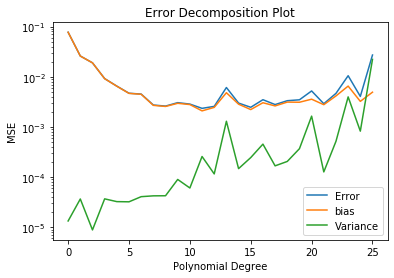

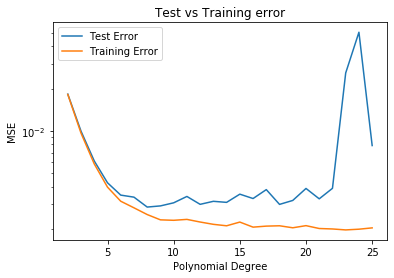

In [247]:
degree, ols_err_tst, ols_err_trn, ols_err_gbl, ols_bias, ols_var = bias_variance(x_array, 
                                                                                 y_array, 
                                                                                 z_array, 
                                                                                 'ols', 
                                                                                 lamb = 0, 
                                                                                 poly_order = 25, 
                                                                                 k=5, 
                                                                                  
                                                                                 printval = True
                                                                                 )

In [267]:
f = open("ols_error_data1", "w+")
f.write('Test Error          Train Error         Global Error        Bias                Variance \n')
for i in range(len(degree)):
    str0 = '{:.10f}'.ljust(15).format(ols_err_tst[i])
    str1 = '{:.10f}'.ljust(15).format(ols_err_trn[i])
    str2 = '{:.10f}'.ljust(15).format(ols_err_gbl[i])
    str3 = '{:.10f}'.ljust(15).format(ols_bias[i])
    str4 = '{:.10f}'.ljust(15).format(ols_var[i])
    
    strt = str0+str1+str2+str3+str4+'\n'       
    f.write(strt)
f.close()           
            
            
            

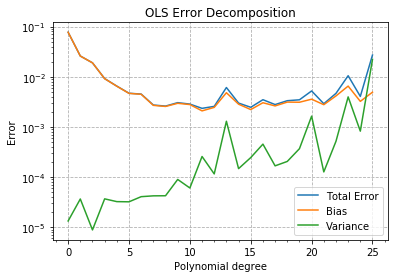

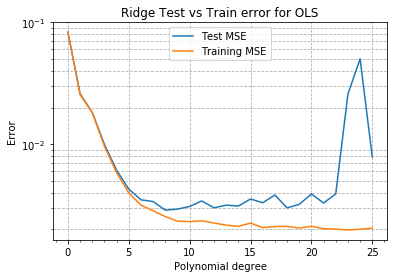

In [429]:
fig, ax = plt.subplots(1)
ax.semilogy(degree, ols_err_gbl, label = 'Total Error')
ax.semilogy(degree, ols_bias, label = 'Bias')
ax.semilogy(degree, ols_var, label = 'Variance')
plt.title('OLS Error Decomposition')
plt.xlabel('Polynomial degree')
plt.ylabel('Error')
#rect = patches.Rectangle((4,2*10e-4),20.9,7e-3,linewidth=1,edgecolor='r', linestyle = '-.', facecolor = 'none')
#ax.add_patch(rect)
ax.grid(linestyle = '--')
plt.xticks(np.arange(0,26,5))
minorLocator   = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
plt.legend()

fig, ax = plt.subplots(1)
plt.semilogy(degree, ols_err_tst, label = 'Test MSE')
plt.semilogy(degree, ols_err_trn, label = 'Training MSE')
plt.title('Ridge Test vs Train error for OLS')
plt.xlabel('Polynomial degree')
plt.ylabel('Error')
#plt.ylim(2*10e-4,10e-3)
ax.grid( axis = 'x', linestyle = '--')
ax.grid( which = 'minor', axis = 'y', linestyle = '--')
minorLocator   = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
plt.legend()

# ridge

In [339]:
error_5, lvec = lambda_error('ridge', x_array, y_array, z_array, 5, lambmax = -3, lambvecsize = 100)
error_8, _ = lambda_error('ridge', x_array, y_array, z_array, 8, lambmax = -3, lambvecsize = 100)
error_10, _ = lambda_error('ridge', x_array, y_array, z_array, 10, lambmax = -3, lambvecsize = 100)
error_12, _ = lambda_error('ridge', x_array, y_array, z_array, 12, lambmax = -3, lambvecsize = 100)
error_14, _ = lambda_error('ridge', x_array, y_array, z_array, 14, lambmax = -3, lambvecsize = 100)
error_16, _ = lambda_error('ridge', x_array, y_array, z_array, 16, lambmax = -3, lambvecsize = 100)
error_18, _ = lambda_error('ridge', x_array, y_array, z_array, 18, lambmax = -3, lambvecsize = 100)



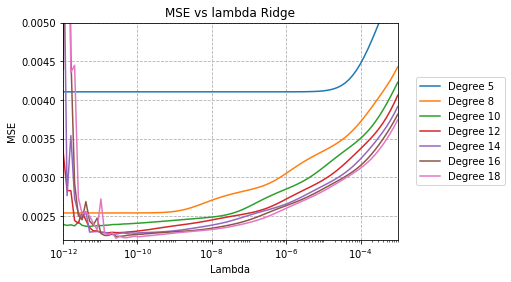

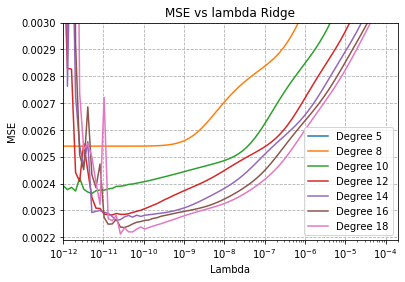

In [423]:
fig, ax = plt.subplots()
plt.title('MSE vs lambda Ridge')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.semilogx(lvec, error_5, label = 'Degree 5')
plt.semilogx(lvec, error_8, label = 'Degree 8')
plt.semilogx(lvec, error_10, label = 'Degree 10')
plt.semilogx(lvec, error_12, label = 'Degree 12')
plt.semilogx(lvec, error_14, label = 'Degree 14')
plt.semilogx(lvec, error_16, label = 'Degree 16')
plt.semilogx(lvec, error_18, label = 'Degree 18')
plt.ylim(2.19*10e-4, 5*10e-4)
plt.xlim(10e-13, 10e-4)
ax.grid( axis = 'x', linestyle = '--')
ax.grid( which = 'major', axis = 'y', linestyle = '--')
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
plt.legend(loc = 'center left', bbox_to_anchor=(1.04, .5))
plt.show()

fig, ax = plt.subplots()
plt.title('MSE vs lambda Ridge')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.semilogx(lvec, error_5, label = 'Degree 5')
plt.semilogx(lvec, error_8, label = 'Degree 8')
plt.semilogx(lvec, error_10, label = 'Degree 10')
plt.semilogx(lvec, error_12, label = 'Degree 12')
plt.semilogx(lvec, error_14, label = 'Degree 14')
plt.semilogx(lvec, error_16, label = 'Degree 16')
plt.semilogx(lvec, error_18, label = 'Degree 18')
plt.ylim(2.19*10e-4, 3*10e-4)
plt.xlim(10e-13, 2*10e-5)
ax.grid( axis = 'x', linestyle = '--')
ax.grid( which = 'major', axis = 'y', linestyle = '--')
plt.legend()
plt.show()

# $\lambda$ = 10^-4, 10^-7, 10^-10

In [350]:
ridge_object = Regression_methods(A, z_array, lamb = 10e-4)

t = no_resample_analysis(ridge_object, method = 'ridge', lamb = 10e-4)

NO RESAMPLE ANALYSIS
MSE:  0.00562279182422531
R2 Score:  0.9313259628588452
----Confidence Intervals for Selected Beta----
β0 = 0.742 +- 0.00142
β2 = -7.93 +- 0.0244
β4 = 8.34 +- 0.0301
β6 = 2.69 +- 0.009
β8 = 0.464 +- 0.0278
β10 = 5.1 +- 0.0317
β12 = 6.23 +- 0.0284
β14 = -5.04 +- 0.0411
β16 = -5.88 +- 0.0379
β18 = 4.96 +- 0.0298
β20 = -5.68 +- 0.0194


In [351]:
ridge_object = Regression_methods(A, z_array, lamb = 10e-7)

t = no_resample_analysis(ridge_object, method = 'ridge', lamb = 10e-7)

NO RESAMPLE ANALYSIS
MSE:  0.0041050240556723345
R2 Score:  0.9498632381782307
----Confidence Intervals for Selected Beta----
β0 = 0.286 +- 0.00223
β2 = -9.86 +- 0.117
β4 = 27.5 +- 0.245
β6 = 9.0 +- 0.0219
β8 = 27.5 +- 0.187
β10 = 17.4 +- 0.0877
β12 = 51.5 +- 0.176
β14 = -2.7 +- 0.0844
β16 = -57.6 +- 0.187
β18 = -28.0 +- 0.232
β20 = 2.9 +- 0.0915


In [352]:
ridge_object = Regression_methods(A, z_array, lamb = 10e-10)

t = no_resample_analysis(ridge_object, method = 'ridge', lamb = 10e-10)

NO RESAMPLE ANALYSIS
MSE:  0.0041048727630711
R2 Score:  0.9498650859922778
----Confidence Intervals for Selected Beta----
β0 = 0.281 +- 0.00225
β2 = -9.87 +- 0.118
β4 = 27.6 +- 0.248
β6 = 9.07 +- 0.0221
β8 = 27.8 +- 0.189
β10 = 17.5 +- 0.0884
β12 = 52.0 +- 0.177
β14 = -2.61 +- 0.0848
β16 = -58.1 +- 0.188
β18 = -28.5 +- 0.234
β20 = 3.06 +- 0.0923


# ridge traing vs test for $\lambda$ = 10^-10

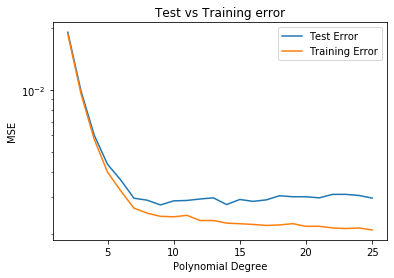

In [353]:
degree, rdg_err_tst, rdg_err_trn, rdg_err_gbl, rdg_bias, rdg_var = bias_variance(x_array, 
                                                                                 y_array, 
                                                                                 z_array, 
                                                                                 'ridge', 
                                                                                 lamb = 10e-10, 
                                                                                 poly_order = 25, 
                                                                                 k=5, 
                                                                                 testtrainplot = True)

In [416]:
f = open("ridge_error_data1", "w+")
f.write('Test Error          Train Error         Global Error        Bias                Variance \n')
for i in range(len(degree)):
    str0 = '{:.10f}'.ljust(15).format(rdg_err_tst[i])
    str1 = '{:.10f}'.ljust(15).format(rdg_err_trn[i])
    str2 = '{:.10f}'.ljust(15).format(rdg_err_gbl[i])
    str3 = '{:.10f}'.ljust(15).format(rdg_bias[i])
    str4 = '{:.10f}'.ljust(15).format(rdg_var[i])
    
    strt = str0+str1+str2+str3+str4+'\n'       
    f.write(strt)
f.close()           

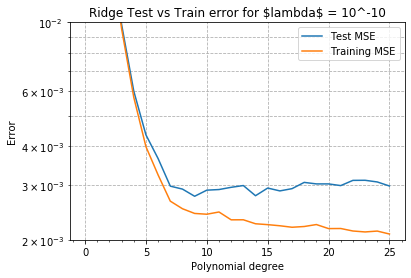

In [419]:
fig, ax = plt.subplots()
plt.semilogy(degree, rdg_err_tst, label = 'Test MSE')
plt.semilogy(degree, rdg_err_trn, label = 'Training MSE')
plt.title('Ridge Test vs Train error for \$lambda$ = 10^-10')
plt.xlabel('Polynomial degree')
plt.ylabel('Error')
plt.ylim(2*10e-4,10e-3)
ax.grid( axis = 'x', linestyle = '--')
ax.grid( which = 'minor', axis = 'y', linestyle = '--')
minorLocator   = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
plt.legend()

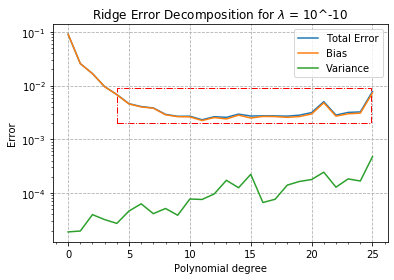

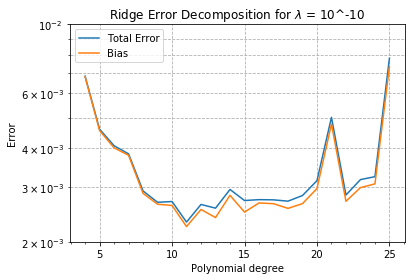

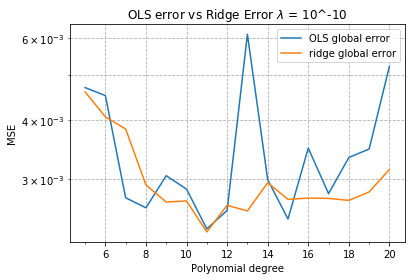

In [430]:
fig, ax = plt.subplots(1)
ax.semilogy(degree, rdg_err_gbl, label = 'Total Error')
ax.semilogy(degree, rdg_bias, label = 'Bias')
ax.semilogy(degree, rdg_var, label = 'Variance')
plt.title('Ridge Error Decomposition for $\lambda$ = 10^-10')
plt.xlabel('Polynomial degree')
plt.ylabel('Error')
rect = patches.Rectangle((4,2*10e-4),20.9,7e-3,linewidth=1,edgecolor='r', linestyle = '-.', facecolor = 'none')
ax.add_patch(rect)
ax.grid(linestyle = '--')
plt.xticks(np.arange(0,26,5))
minorLocator   = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
plt.legend()

fig, ax = plt.subplots()
plt.semilogy(degree[4:], rdg_err_gbl[4:], label = 'Total Error')
plt.semilogy(degree[4:], rdg_bias[4:], label = 'Bias')
plt.title('Ridge Error Decomposition for $\lambda$ = 10^-10')
plt.xlabel('Polynomial degree')
plt.ylabel('Error')
plt.ylim(2*10e-4,10e-3)
ax.grid( axis = 'x', linestyle = '--')
ax.grid( which = 'minor', axis = 'y', linestyle = '--')
minorLocator   = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
plt.legend()

fig, ax = plt.subplots()
plt.semilogy(degree[5:21], ols_err_gbl[5:21], label = 'OLS global error')
plt.semilogy(degree[5:21], rdg_err_gbl[5:21], label = 'ridge global error')
plt.title('OLS error vs Ridge Error $\lambda$ = 10^-10')
plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
ax.grid( axis = 'x', linestyle = '--')
ax.grid( which = 'minor', axis = 'y', linestyle = '--')
minorLocator   = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
plt.legend()
plt.show()


# LASSO

In [460]:
lasso_error_5, lvec = lambda_error('lasso', x_array, y_array, z_array, 5, lambmax = -3, lambvecsize = 100)
lasso_error_8, _ = lambda_error('lasso', x_array, y_array, z_array, 8, lambmax = -3, lambvecsize = 100)
lasso_error_10, _ = lambda_error('lasso', x_array, y_array, z_array, 10, lambmax = -3, lambvecsize = 100)
lasso_error_12, _ = lambda_error('lasso', x_array, y_array, z_array, 12, lambmax = -3, lambvecsize = 100)
lasso_error_14, _ = lambda_error('lasso', x_array, y_array, z_array, 14, lambmax = -3, lambvecsize = 100)
lasso_error_16, _ = lambda_error('lasso', x_array, y_array, z_array, 16, lambmax = -3, lambvecsize = 100)
lasso_error_18, _ = lambda_error('lasso', x_array, y_array, z_array, 18, lambmax = -3, lambvecsize = 100)


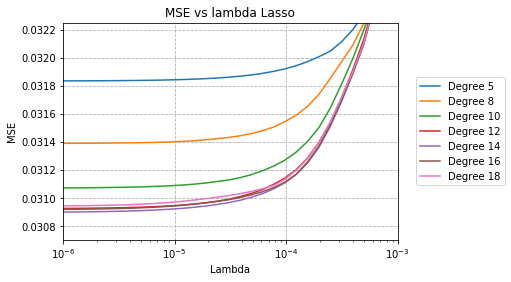

In [468]:
fig, ax = plt.subplots()
plt.title('MSE vs lambda Lasso')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.semilogx(lvec, lasso_error_5, label = 'Degree 5')
plt.semilogx(lvec, lasso_error_8, label = 'Degree 8')
plt.semilogx(lvec, lasso_error_10, label = 'Degree 10')
plt.semilogx(lvec, lasso_error_12, label = 'Degree 12')
plt.semilogx(lvec, lasso_error_14, label = 'Degree 14')
plt.semilogx(lvec, lasso_error_16, label = 'Degree 16')
plt.semilogx(lvec, lasso_error_18, label = 'Degree 18')
plt.ylim(3.07e-2, 3.225e-2)
plt.xlim(10e-7, 10e-4)
ax.grid( axis = 'x', linestyle = '--')
ax.grid( which = 'major', axis = 'y', linestyle = '--')
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
plt.legend(loc = 'center left', bbox_to_anchor=(1.04, .5))
plt.show()

# from plots choose $\lambda$ = 5 *10^-6

In [469]:
degree, las_err_tst, las_err_trn, las_err_gbl, las_bias, las_var = bias_variance(x_array, 
                                                                                 y_array, 
                                                                                 z_array, 
                                                                                 'lasso', 
                                                                                 lamb = 5*10e-6, 
                                                                                 poly_order = 25, 
                                                                                 k=5)

In [470]:
f = open("lasso_error_data1", "w+")
f.write('Test Error          Train Error         Global Error        Bias                Variance \n')
for i in range(len(degree)):
    str0 = '{:.10f}'.ljust(15).format(las_err_tst[i])
    str1 = '{:.10f}'.ljust(15).format(las_err_trn[i])
    str2 = '{:.10f}'.ljust(15).format(las_err_gbl[i])
    str3 = '{:.10f}'.ljust(15).format(las_bias[i])
    str4 = '{:.10f}'.ljust(15).format(las_var[i])
    
    strt = str0+str1+str2+str3+str4+'\n'       
    f.write(strt)
f.close()

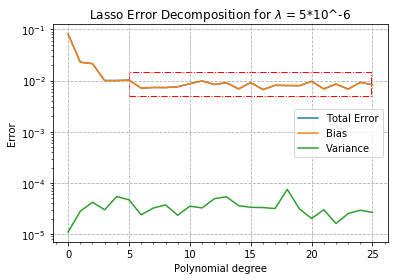

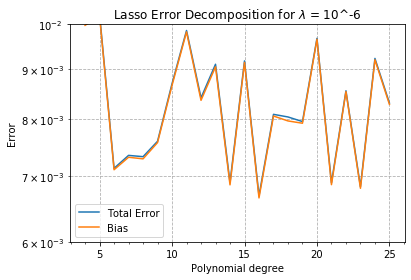

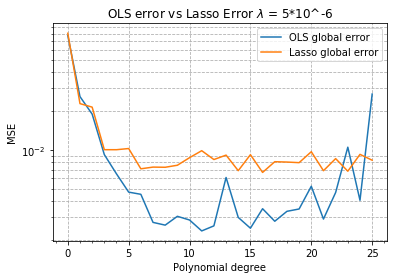

In [485]:
fig, ax = plt.subplots(1)
ax.semilogy(degree, las_err_gbl, label = 'Total Error')
ax.semilogy(degree, las_bias, label = 'Bias')
ax.semilogy(degree, las_var, label = 'Variance')
plt.title('Lasso Error Decomposition for $\lambda$ = 5*10^-6')
plt.xlabel('Polynomial degree')
plt.ylabel('Error')
rect = patches.Rectangle((5,5e-3),19.9,1e-2,linewidth=1,edgecolor='r', linestyle = '-.', facecolor = 'none')
ax.add_patch(rect)
ax.grid(linestyle = '--')
plt.xticks(np.arange(0,26,5))
minorLocator   = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
plt.legend()

fig, ax = plt.subplots()
plt.semilogy(degree[4:], las_err_gbl[4:], label = 'Total Error')
plt.semilogy(degree[4:], las_bias[4:], label = 'Bias')
plt.title('Lasso Error Decomposition for $\lambda$ = 10^-6')
plt.xlabel('Polynomial degree')
plt.ylabel('Error')
plt.ylim(6e-3,1e-2)
ax.grid( axis = 'x', linestyle = '--')
ax.grid( which = 'minor', axis = 'y', linestyle = '--')
minorLocator   = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
plt.legend()

fig, ax = plt.subplots()
plt.semilogy(degree, ols_err_gbl, label = 'OLS global error')
plt.semilogy(degree, las_err_gbl, label = 'Lasso global error')
plt.title('OLS error vs Lasso Error $\lambda$ = 5*10^-6')
plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
ax.grid( axis = 'x', linestyle = '--')
ax.grid( which = 'minor', axis = 'y', linestyle = '--')
minorLocator   = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
plt.legend()
plt.show()


(-0.5, 3600.5, 3600.5, -0.5)

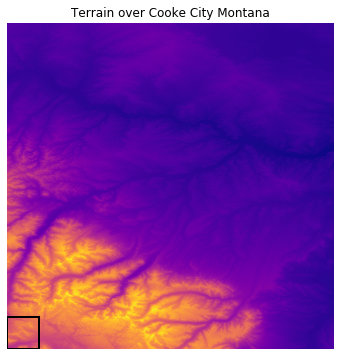

In [509]:

from imageio import imread
%matplotlib inline
# Load the terrain
terrain1 = imread('cooke_city.tif')
# Show the terrain
fig, ax = plt.subplots(figsize = (6,6))
plt.title('Terrain over Cooke City Montana')
plt.imshow(terrain1, cmap='plasma')
rect = patches.Rectangle((0,3250),350,350,linewidth=2,edgecolor='k', linestyle = '-', facecolor = 'none')
ax.add_patch(rect)
plt.axis('off')



3222 2250


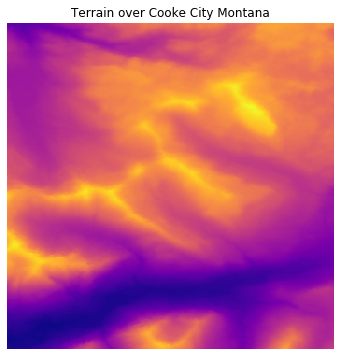

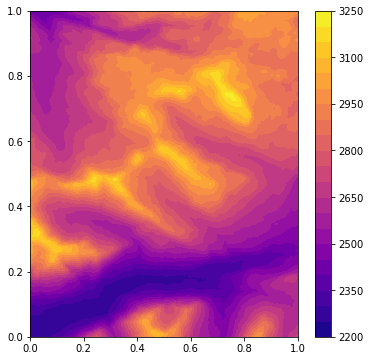

In [521]:
#bottom left corner of map
import matplotlib
from imageio import imread
%matplotlib inline
# Load the terrain
terrain1 = imread('cooke_city.tif')
# Show the terrain
fig, ax = plt.subplots(figsize=(6,6))
plt.title('Terrain over Cooke City Montana')
ax.imshow(terrain1[3251:,:350], cmap='plasma')

plt.axis('off')
print(np.amax(terrain1[3251:,:350]), np.amin(terrain1[3251:,:350]))

x = np.linspace(0,1,350)
y = np.linspace(1,0,350)

x, y = np.meshgrid(x,y)
z = terrain1[3251:,:350]

z_terrain = z.ravel()
#z_terrain = (z-np.mean(z))/np.std(z)
x_terrain = x.ravel()
y_terrain = y.ravel()


fig, ax = plt.subplots(figsize=(6,6))
plt.tricontourf(x_terrain,y_terrain,z_terrain, np.arange(2200,3300,50), cmap = 'plasma')
plt.colorbar()
plt.show()

#data_out, _, _, _, _, error_global, bias_global, var_global = my_kfold(x, y, z, 'ols', lamb = 0, order = 13, k=5)
#data_out = data_out[np.lexsort((data_out[:,1],data_out[:,0]))]
#fig = plt.figure()
#plt.tricontourf(data_out[:,0],data_out[:,1],data_out[:,2],np.arange(2200,3200,50), cmap = 'plasma')
#plt.colorbar()
#plt.show()


# OLS

In [516]:
A = build_design_matrix(x_terrain, y_terrain, 5)

ols_object = Regression_methods(A, z_terrain, lamb = 0)

test = no_resample_analysis(ols_object, method = 'ols', lamb = 0)

NO RESAMPLE ANALYSIS
MSE:  0.24308394654685497
R2 Score:  0.756916053453145
----Confidence Intervals for Selected Beta----
β0 = -2.45 +- 0.000112
β2 = 64.4 +- 0.00596
β4 = 3.04e+02 +- 0.0139
β6 = -3.05 +- 0.00124
β8 = 3.5e+02 +- 0.0099
β10 = 23.3 +- 0.00475
β12 = 83.4 +- 0.0099
β14 = 1.51e+02 +- 0.00463
β16 = 40.0 +- 0.0106
β18 = 1.43e+02 +- 0.0139
β20 = -43.1 +- 0.00546


In [522]:
degree, t_ols_err_tst, t_ols_err_trn, t_ols_err_gbl, t_ols_bias, t_ols_var = bias_variance(x_terrain, 
                                                                                 y_terrain, 
                                                                                 z_terrain, 
                                                                                 'ols', 
                                                                                 lamb = 0, 
                                                                                 poly_order = 25, 
                                                                                 k=5, 
                                                                                  
                                                                                 printval = True)



polynomial degree:  0
R2 test is:  -4.4408920985006264e-17
Error test is:  44326.03887285818
-------------------------------
Global error is:  44662.828064181245
bias is:  44662.7268516627
variance is:  0.10121251854807597
4.4663e+04 >= 4.4663e+04 + 0.10121 = 4.4663e+04




polynomial degree:  1
R2 test is:  0.29918600594449885
Error test is:  31195.784541844245
-------------------------------
Global error is:  30810.193126213195
bias is:  30809.951217445665
variance is:  0.2419087675226941
3.081e+04 >= 3.081e+04 + 0.24191 = 3.081e+04




polynomial degree:  2
R2 test is:  0.43990856691084856
Error test is:  24893.563982930376
-------------------------------
Global error is:  24661.228425643094
bias is:  24660.644356836165
variance is:  0.5840688069257849
2.4661e+04 >= 2.4661e+04 + 0.58407 = 2.4661e+04




polynomial degree:  3
R2 test is:  0.5859869842843548
Error test is:  18352.057136486423
-------------------------------
Global error is:  18351.682867930213
bias is:  18351.110633

In [524]:
f = open("terrain_ols_error_data1", "w+")
f.write('Test Error          Train Error         Global Error        Bias                Variance \n')
for i in range(len(degree)):
    str0 = '{:.13f}'.ljust(15).format(t_ols_err_tst[i])
    str1 = '{:.13f}'.ljust(15).format(t_ols_err_trn[i])
    str2 = '{:.13f}'.ljust(15).format(t_ols_err_gbl[i])
    str3 = '{:.13f}'.ljust(15).format(t_ols_bias[i])
    str4 = '{:.13f}'.ljust(15).format(t_ols_var[i])
    
    strt = str0+str1+str2+str3+str4+'\n'       
    f.write(strt)
f.close()  

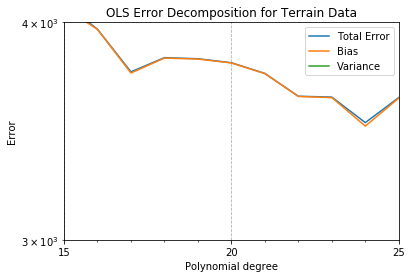

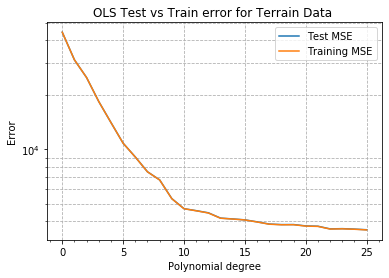

In [532]:
fig, ax = plt.subplots(1)
ax.semilogy(degree, t_ols_err_gbl, label = 'Total Error')
ax.semilogy(degree, t_ols_bias, label = 'Bias')
ax.semilogy(degree, t_ols_var, label = 'Variance')
plt.title('OLS Error Decomposition for Terrain Data')
plt.xlabel('Polynomial degree')
plt.ylabel('Error')
plt.ylim(3e3,4e3)
plt.xlim(15,25)
#rect = patches.Rectangle((4,2*10e-4),20.9,7e-3,linewidth=1,edgecolor='r', linestyle = '-.', facecolor = 'none')
#ax.add_patch(rect)
ax.grid(linestyle = '--')
plt.xticks(np.arange(15,26,5))
minorLocator   = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
plt.legend()

fig, ax = plt.subplots(1)
plt.semilogy(degree, t_ols_err_tst, label = 'Test MSE')
plt.semilogy(degree, t_ols_err_trn, label = 'Training MSE')
plt.title('OLS Test vs Train error for Terrain Data ')
plt.xlabel('Polynomial degree')
plt.ylabel('Error')
#plt.ylim(2*10e-4,10e-3)
ax.grid( axis = 'x', linestyle = '--')
ax.grid( which = 'minor', axis = 'y', linestyle = '--')
minorLocator   = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
plt.legend()